
# NN Decoder and Flat Minima: Loss Landscape Exploration (Fast Version)

This notebook accompanies the subsection on *Discovery of Flat Regions in the Energy Landscape*.

This is a **lightweight version** designed to run quickly on a laptop:

- Smaller training set.
- Fewer SGD steps.
- Same qualitative behavior (noisy vs smooth SGD, Hessian spectra, 2D slice).

Figures are saved into a local `figs/` directory for inclusion in the book.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)
np.random.seed(0)


Using device: cpu



## 1. Three-bit parity-check code and noisy channel


In [2]:

codewords = torch.tensor(
    [[0., 0., 0.],
     [1., 1., 0.],
     [1., 0., 1.],
     [0., 1., 1.]],
    dtype=torch.float32,
)

def sample_dataset(n_samples=1500, noise_std=0.4):
    idx = torch.randint(low=0, high=codewords.shape[0], size=(n_samples,))
    x_true = codewords[idx]
    noise = noise_std * torch.randn_like(x_true)
    y_obs = x_true + noise
    return y_obs, x_true

X_train, Y_train = sample_dataset(n_samples=1500, noise_std=0.4)
X_test,  Y_test  = sample_dataset(n_samples=500, noise_std=0.4)

print("Train set:", X_train.shape, Y_train.shape)
print("Test set: ", X_test.shape, Y_test.shape)


Train set: torch.Size([1500, 3]) torch.Size([1500, 3])
Test set:  torch.Size([500, 3]) torch.Size([500, 3])



## 2. Neural network decoder


In [3]:

class NNDecoder(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3),
        )

    def forward(self, x):
        return self.net(x)


def bce_loss_logits(logits, targets):
    return nn.functional.binary_cross_entropy_with_logits(
        logits, targets
    )



## 3. Training with different batch sizes (fixed number of SGD steps)


In [4]:

def train_decoder_fixed_steps(batch_size, lr=5e-3, max_steps=8000, hidden_dim=8):
    model = NNDecoder(hidden_dim=hidden_dim).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    if batch_size == "full":
        bs = len(X_train)
    else:
        bs = batch_size

    train_ds = TensorDataset(X_train.to(device), Y_train.to(device))
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    loader_iter = iter(train_loader)

    loss_hist = []

    step = 0
    while step < max_steps:
        try:
            xb, yb = next(loader_iter)
        except StopIteration:
            loader_iter = iter(train_loader)
            xb, yb = next(loader_iter)

        optimizer.zero_grad()
        logits = model(xb)
        loss = bce_loss_logits(logits, yb)
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.item())
        step += 1

    return model, np.array(loss_hist)


Training with batch size = 4
Training with batch size = 32
Training with batch size = full


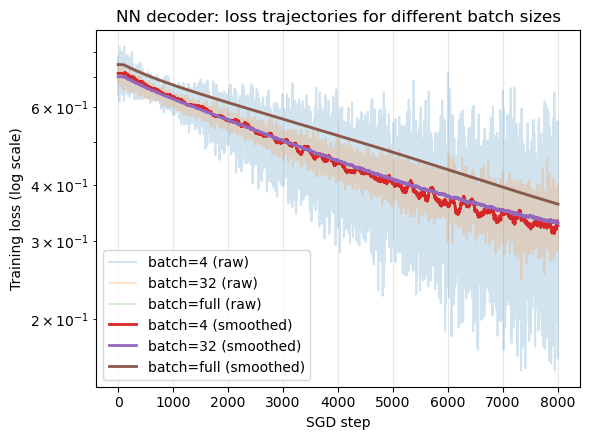

In [5]:

batch_settings = [4, 32, "full"]
lr = 5e-3
max_steps = 8000
hidden_dim = 8

trained_models = {}
loss_histories = {}

for bs in batch_settings:
    print(f"Training with batch size = {bs}")
    model_bs, loss_bs = train_decoder_fixed_steps(
        batch_size=bs, lr=lr, max_steps=max_steps, hidden_dim=hidden_dim
    )
    trained_models[bs] = model_bs
    loss_histories[bs] = loss_bs

def moving_average(x, window=100):
    if len(x) < window:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    ma = (cumsum[window:] - cumsum[:-window]) / window
    pad = np.full(window - 1, ma[0])
    return np.concatenate([pad, ma])

plt.figure(figsize=(6, 4.5))
for bs in batch_settings:
    steps = np.arange(len(loss_histories[bs]))
    label = f"batch={bs}"
    plt.plot(steps, loss_histories[bs], alpha=0.2, label=label + " (raw)")

for bs in batch_settings:
    steps = np.arange(len(loss_histories[bs]))
    sm = moving_average(loss_histories[bs], window=100)
    plt.plot(steps, sm, linewidth=2, label=f"batch={bs} (smoothed)")

plt.yscale("log")
plt.xlabel("SGD step")
plt.ylabel("Training loss (log scale)")
plt.title("NN decoder: loss trajectories for different batch sizes")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figs/nn_decoding_loss_vs_step_batches.png", dpi=300, bbox_inches="tight")
plt.show()


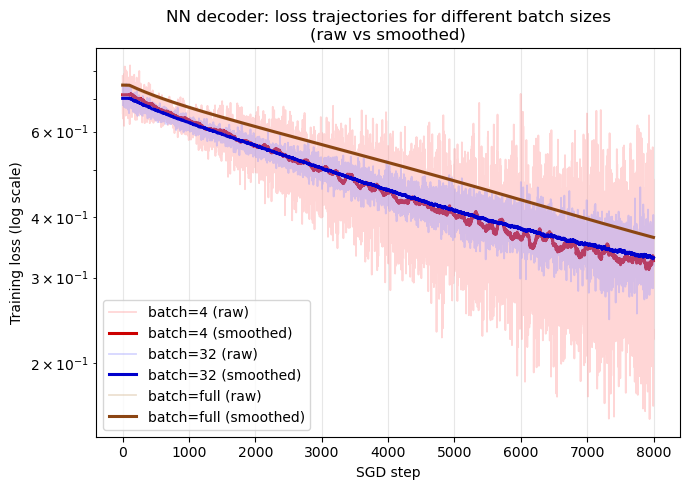

In [8]:
# ------------------------------------------
# PLOT: raw + smoothed loss with aligned colors (color-correction)
# ------------------------------------------

color_map = {
    4: ("#ff9999", "#cc0000"),        # light red, deep red
    32: ("#9999ff", "#0000cc"),      # light blue, deep blue
    "full": ("#d2b48c", "#8b4513"),  # tan, saddle brown
}

plt.figure(figsize=(7, 5))

for bs in batch_settings:
    raw_color, smooth_color = color_map[bs]
    steps = np.arange(len(loss_histories[bs]))

    # RAW (light)
    plt.plot(
        steps,
        loss_histories[bs],
        color=raw_color,
        alpha=0.40,
        linewidth=1.3,
        label=f"batch={bs} (raw)",
    )

    # SMOOTHED (dark)
    sm = moving_average(loss_histories[bs], window=100)
    plt.plot(
        steps,
        sm,
        color=smooth_color,
        linewidth=2.2,
        label=f"batch={bs} (smoothed)",
    )

plt.yscale("log")
plt.xlabel("SGD step")
plt.ylabel("Training loss (log scale)")
plt.title("NN decoder: loss trajectories for different batch sizes\n(raw vs smoothed)")
plt.grid(alpha=0.30)
plt.legend()
plt.tight_layout()
plt.savefig("figs/nn_decoding_loss_vs_step_batches.png", dpi=300, bbox_inches="tight")
plt.show()



## 4. Hessian spectrum near the trained solutions


Computing Hessian for batch size = 4 solution
Computing Hessian for batch size = 32 solution
Computing Hessian for batch size = full solution


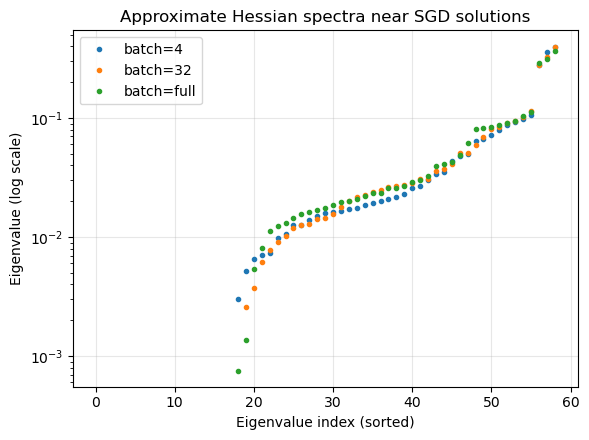

In [6]:

def flatten_params(model):
    return torch.cat([p.reshape(-1) for p in model.parameters()])

def hessian_full(model, x_batch, y_batch):
    model.zero_grad()
    logits = model(x_batch)
    loss = bce_loss_logits(logits, y_batch)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    g_flat = torch.cat([g.reshape(-1) for g in grads])

    P = g_flat.numel()
    H = torch.zeros(P, P, dtype=torch.float32, device=g_flat.device)

    for i in range(P):
        grad2 = torch.autograd.grad(g_flat[i], model.parameters(), retain_graph=True)
        H[:, i] = torch.cat([g.reshape(-1) for g in grad2]).detach()

    return H.cpu()

hess_batch_size = 64
x_hess, y_hess = X_train[:hess_batch_size].to(device), Y_train[:hess_batch_size].to(device)

eigvals_dict = {}

for bs in batch_settings:
    print(f"Computing Hessian for batch size = {bs} solution")
    model_bs = trained_models[bs].to(device)
    H_bs = hessian_full(model_bs, x_hess, y_hess)
    eigvals = np.linalg.eigvalsh(H_bs.numpy())
    eigvals_dict[bs] = eigvals

plt.figure(figsize=(6, 4.5))
for bs in batch_settings:
    eigvals = eigvals_dict[bs]
    plt.semilogy(np.arange(len(eigvals)), np.sort(eigvals), marker="o",
                 linestyle="none", markersize=3, label=f"batch={bs}")
plt.xlabel("Eigenvalue index (sorted)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Approximate Hessian spectra near SGD solutions")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figs/nn_decoding_hessian_spectra_batches.png", dpi=300, bbox_inches="tight")
plt.show()



## 5. A 2D slice of the loss surface (tangent-plane slice)


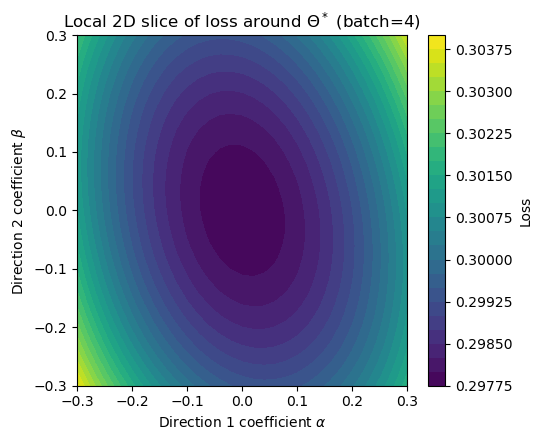

In [7]:

bs_ref = 4
model_ref = trained_models[bs_ref].to(device)

theta_star = flatten_params(model_ref).detach()
P = theta_star.numel()

model_ref.zero_grad()
for p in model_ref.parameters():
    p.requires_grad_(True)

x_eval, y_eval = X_train[:hess_batch_size].to(device), Y_train[:hess_batch_size].to(device)
logits = model_ref(x_eval)
loss_center = bce_loss_logits(logits, y_eval)
grads = torch.autograd.grad(loss_center, model_ref.parameters())
g_flat = torch.cat([g.reshape(-1) for g in grads]).detach()
g_norm2 = (g_flat @ g_flat).item()

d1 = torch.randn(P)
d2 = torch.randn(P)

if g_norm2 > 0:
    d1 = d1 - (d1 @ g_flat) / g_norm2 * g_flat
    d2 = d2 - (d2 @ g_flat) / g_norm2 * g_flat

d1 = d1 / d1.norm()
d2 = d2 - (d2 @ d1) * d1
d2 = d2 / d2.norm()

grid_lim = 0.3
n_grid = 31
alphas = torch.linspace(-grid_lim, grid_lim, n_grid)
betas  = torch.linspace(-grid_lim, grid_lim, n_grid)

Z = torch.zeros(n_grid, n_grid)

def set_params_from_theta(model, theta):
    offset = 0
    with torch.no_grad():
        for p in model.parameters():
            numel = p.numel()
            p.copy_(theta[offset:offset+numel].view_as(p))
            offset += numel

for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        theta_pert = theta_star + a * d1 + b * d2
        set_params_from_theta(model_ref, theta_pert.to(device))
        logits = model_ref(x_eval)
        loss_val = bce_loss_logits(logits, y_eval).item()
        Z[j, i] = loss_val

A, B = torch.meshgrid(alphas, betas, indexing="xy")

plt.figure(figsize=(5.5, 4.5))
cs = plt.contourf(A.numpy(), B.numpy(), Z.numpy(), levels=25)
plt.colorbar(cs, label="Loss")
plt.xlabel(r"Direction 1 coefficient $\alpha$")
plt.ylabel(r"Direction 2 coefficient $\beta$")
plt.title(r"Local 2D slice of loss around $\Theta^*$ (batch=%s)" % bs_ref)
plt.tight_layout()
plt.savefig("figs/nn_decoding_loss_contour_batch4.png", dpi=300, bbox_inches="tight")
plt.show()
